## Get the shortest route to cover all the major Landmarks on the Map

#### The route obtained by the Algorithms can be used for navigation of the Driverless cars, or simply selecting the order of traveling given set of points. The data is taken from the NYC Taxi Rides dataset. 

Steps to follow:   
- Get the data from BigQuery (Extract Latitude - Longitude information) .  
- Project the latitude Longitude points on the Geomap   .
- Get the data ready for the TSP Algorithms i.e. (x, y) coordinates and distance between them .  
- Pass the data to the Algorithms and get the route covering the Shortest distance .  
- Plot the path onto the map . 


#### Getting the data from BigQuery

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
from TSPAlgos import nearest_neighbor, self_organizing_map, simulated_annealing

**Run just once to get the data locally**

In [3]:
from google.cloud import bigquery
client = bigquery.Client()

sql = """
SELECT DISTINCT start_station_latitude, start_station_longitude 
FROM `bigquery-public-data.new_york.citibike_trips`
"""
df = client.query(sql).to_dataframe()


In [5]:
#Save locally since there are very less data points
df.to_csv('data/nyc_geolocation.csv')

### Exploration

In [3]:
df = pd.read_csv('data/nyc_geolocation.csv')

In [4]:
df = df.iloc[:, 1:]

In [5]:
df.head()

start_station_latitude  start_station_longitude
0               40.721791               -73.950415
1               40.756604               -73.997901
2               40.718939               -73.992663
3               40.695065               -73.987167
4               40.764618               -73.987895

In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
geometry = [Point(xy) for xy in zip(df['start_station_longitude'], df['start_station_latitude'])]  #Creates a Point Object that can be plotted
crs = {'init':'epsg:4326'}
geodf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)  #GeoDataFrame can be plotted on the Map


In [9]:
street_map = gpd.read_file('ShapeFiles/nyu_2451_34505.shp')

In [10]:
geodf['start_station_latitude'].min(), geodf['start_station_latitude'].max()

(40.44535, 40.804213)

In [41]:
geodf.shape

(698, 3)

In [11]:
import random

In [12]:
take = random.sample(list(range(len(geodf))), 200)

In [13]:
points = geodf.iloc[take].reset_index()

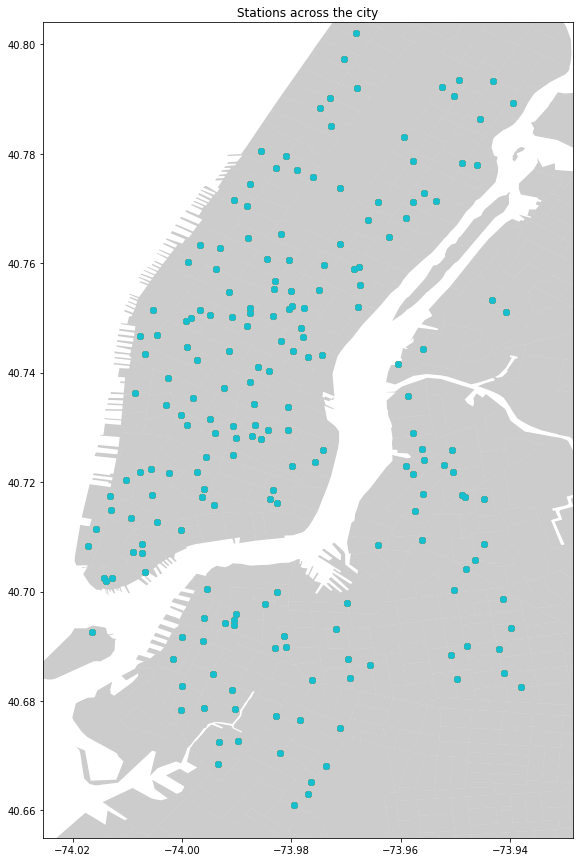

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

for i in range(len(points)):
    points['geometry'].plot(ax=ax, marker='o')
minx, miny, maxx, maxy = -74.02544975280000, 40.65500, -73.92850399017300, 40.80400
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title('Stations across the city')
plt.show()

## Next Step: converting it to TSP problem, by taking indiviual points as (x, y) and finding distances between them.

In [15]:
def distance(lat1, long1, lat2, long2):
        """
        start_x, start_y, end
        """
        degrees_to_radians = math.pi/180.0
        phi1 = (90.0 - lat1)*degrees_to_radians
        phi2 = (90.0 - lat2)*degrees_to_radians

        theta1 = long1*degrees_to_radians
        theta2 = long2*degrees_to_radians

        a = ((math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2)) +(math.cos(phi1)*math.cos(phi2)))
        if a>1:
            a=0.999999
        dis = math.acos( a )
        return dis*6373


In [16]:
nodes = points.iloc[:, 1:3].values.tolist()

#### Importing the TSP Algorithms
**Checkout the TSPAlgos Folder to see the complete implementation and code.**

In [17]:
from TSPAlgos import nearest_neighbor, self_organizing_map, simulated_annealing

**Nearest Neighbor Algorithm**

In [18]:
path, shortest_distance = nearest_neighbor.main(nodes)

**Self-Organizing Maps**

In [19]:
path1, shortest_distance1 = self_organizing_map.main(nodes)

**Simulated Annealing Algorithm**

In [20]:
path2, shortest_distance2 = simulated_annealing.main(nodes)

## Trying to plot the path

In [21]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import LineString
import folium

1. Converting each (x,y) coordinate to Point object . 

In [22]:
vals = []
for i in range(len(path)):
    vals.append(Point(path[i][1], path[i][0]))

In [23]:
toplot = gpd.GeoDataFrame(vals, columns=['geometry'])

In [24]:
toplot.head()

geometry
0               POINT (-73.99037292 40.6786115)
1  POINT (-73.99079024791719 40.68199044270703)
2         POINT (-73.99440328999999 40.6849894)
3               POINT (-73.99990419 40.6828003)
4         POINT (-74.00014502000001 40.6783563)

2. Plotting the stops on the map .  

In [25]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 2.5, 
                            fill = True,
                            fill_color = '#F50057',
                            fill_opacity = 0.75,
                            color = 'whitesmoke',
                            weight = 0.5).add_to(mapobj)
    return mapobj


f = folium.Figure(height = 400)
m = folium.Map([40.7555000, -73.9857400], zoom_start = 12.255, tiles='Cartodb dark_matter',no_wrap=True, max_bounds=True, no_touch=True)
m.add_to(f)

add_markers(m, toplot)


3. Making Line-segments to connect the points on the map that shows the shortest path given by the Algorithm .  

In [26]:
def make_lines(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out

In [27]:
# initialize an output DataFrame
df = pd.DataFrame(columns = ['id', 'geometry'])

# Loop through each row of the input point GeoDataFrame
x = 0
while x < len(toplot) - 1:
    df = make_lines(toplot, df, x)
    x = x + 1
    
df.head()

id                                           geometry
0  0  LINESTRING (-73.99037292 40.6786115, -73.99079...
0  1  LINESTRING (-73.99079024791719 40.681990442707...
0  2  LINESTRING (-73.99440328999999 40.6849894, -73...
0  3  LINESTRING (-73.99990419 40.6828003, -74.00014...
0  4  LINESTRING (-74.00014502000001 40.6783563, -73...

In [28]:
crs = {'init': 'epsg:4326'}
gdf_line = GeoDataFrame(df, crs=crs)
gdf_line.head()

id                                           geometry
0  0  LINESTRING (-73.99037292 40.6786115, -73.99079...
0  1  LINESTRING (-73.99079024791719 40.681990442707...
0  2  LINESTRING (-73.99440328999999 40.6849894, -73...
0  3  LINESTRING (-73.99990419 40.6828003, -74.00014...
0  4  LINESTRING (-74.00014502000001 40.6783563, -73...

In [29]:
f = folium.Figure(height = 400)
m = folium.Map([40.7555000, -73.9857400], zoom_start = 12.255, tiles='Cartodb dark_matter',no_wrap=True, max_bounds=True, no_touch=True)
m.add_to(f)

add_markers(m, toplot)

folium.GeoJson(gdf_line).add_to(m)
m


**Yeaaaah, finally plotted the points :)**

### Making a Generic function to plot the Shortest paths given by Algorithms

In [30]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(
            location = coord,
            radius = 2.5, 
            fill = True,
            fill_color = '#F50057',
            fill_opacity = 0.75,
            color = 'whitesmoke',
            weight = 0.5).add_to(mapobj)
    return mapobj



def make_lines(gdf, df_out, i, geometry = 'geometry'):
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out



def plot_path(path):
    #converting (x, y) to Point Object
    vals = []
    for i in range(len(path)):
        vals.append(Point(path[i][1], path[i][0]))

    toplot = gpd.GeoDataFrame(vals, columns=['geometry'])

    # initialize an output DataFrame
    df = pd.DataFrame(columns = ['id', 'geometry'])

    # Loop through each row of the input point GeoDataFrame
    x = 0
    while x < len(toplot) - 1:
        df = make_lines(toplot, df, x)
        x = x + 1

    crs = {'init': 'epsg:4326'}
    gdf_line = GeoDataFrame(df, crs=crs)

    f = folium.Figure(height = 400)
    m = folium.Map([40.7555000, -73.9857400], zoom_start = 12.255, \
                   tiles='Cartodb dark_matter',no_wrap=True, max_bounds=True, no_touch=True)
    m.add_to(f)

    add_markers(m, toplot)

    folium.GeoJson(gdf_line).add_to(m)
    return m


### Nearest Neighbor Route

In [31]:
plot_path(path)

### Self Organizing Map Route

In [33]:
plot_path(path1)

### Simulated Annealing Route

In [34]:
plot_path(path2)

### As it can be clearly seen, the Self-Organizing Maps gives out the best connected path among all other Algorithms. One would expect Nearest Neighbor to give out better results, but that isn't the case.

### Trying SOM for 300, 400, 500, and 698 city stops (Total 698 Stops available)

## 300 STOPS

In [43]:
take = random.sample(list(range(len(geodf))), 300)
points = geodf.iloc[take].reset_index()
nodes = points.iloc[:, 1:3].values.tolist()

#NN Algo
path, shortest_distance = nearest_neighbor.main(nodes)
plot_path(path)

In [47]:
#SOM Algo
path1, shortest_distance1 = self_organizing_map.main(nodes)

In [45]:
plot_path(path1)

In [46]:
#SA Algo
path2, shortest_distance2 = simulated_annealing.main(nodes)
plot_path(path2)

## 400 Stops

In [48]:
take = random.sample(list(range(len(geodf))), 400)
points = geodf.iloc[take].reset_index()
nodes = points.iloc[:, 1:3].values.tolist()

#NN Algo
path, shortest_distance = nearest_neighbor.main(nodes)
plot_path(path)

In [49]:
#SOM Algo
path1, shortest_distance1 = self_organizing_map.main(nodes)
plot_path(path1)

In [50]:
#SA Algo
path2, shortest_distance2 = simulated_annealing.main(nodes)
plot_path(path2)

## 500 Stops

In [35]:
take = random.sample(list(range(len(geodf))), 500)
points = geodf.iloc[take].reset_index()
nodes = points.iloc[:, 1:3].values.tolist()

#NN Algo
path, shortest_distance = nearest_neighbor.main(nodes)

#SOM Algo
path1, shortest_distance1 = self_organizing_map.main(nodes)

#SA Algo
path2, shortest_distance2 = simulated_annealing.main(nodes)
plot_path(path2)

In [36]:
#NN
plot_path(path)

In [37]:
#SOM
plot_path(path1)

## All Stops

In [51]:
take = random.sample(list(range(len(geodf))), 698)
points = geodf.iloc[take].reset_index()
nodes = points.iloc[:, 1:3].values.tolist()

#NN Algo
path, shortest_distance = nearest_neighbor.main(nodes)
plot_path(path)

In [52]:
#SOM Algo
path1, shortest_distance1 = self_organizing_map.main(nodes)
plot_path(path1)

In [53]:
#SA Algo
path2, shortest_distance2 = simulated_annealing.main(nodes)
plot_path(path2)